In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# 폰트 설정 (한글 시각화용)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 불러오기
df = pd.read_excel('서울대기오염_2019.xlsx')

# 2. 컬럼 정리
df.columns = ['날짜', '측정소명', '미세먼지', '초미세먼지', '오존', '이산화질소', '일산화탄소', '아황산가스']

# 3. 날짜 정제
df = df[pd.to_datetime(df['날짜'], errors='coerce').notnull()]
df['날짜'] = pd.to_datetime(df['날짜'])


/tmp/ipykernel_71609/1151047574.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df[pd.to_datetime(df['날짜'], errors='coerce').notnull()]


In [2]:
# 결측치에 대한 평균 값 검증

# 검증 １번、 각 날짜별 측정소 수 카운트
count_by_day = (
    df[df['측정소명'] != '평균']
    .groupby('날짜')['미세먼지']
    .count()
)

# 25개(측정소 수)보다 적은 날만 필터링
dates_with_missing = count_by_day[count_by_day < 25]

print("결측치 있는 날짜 수:", dates_with_missing.shape[0])
print(dates_with_missing.head())

결측치 있는 날짜 수: 85
날짜
2019-07-02    24
2019-07-09    24
2019-07-12    24
2019-07-13    23
2019-07-14    22
Name: 미세먼지, dtype: int64


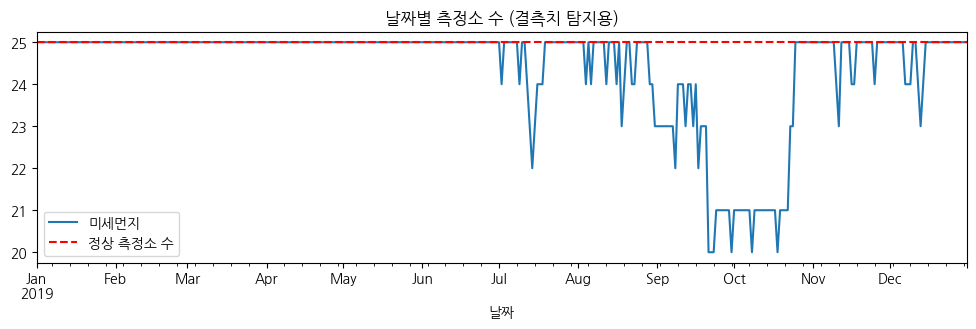

In [3]:
import matplotlib.pyplot as plt

counts = df[df['측정소명'] != '평균'].groupby('날짜')['미세먼지'].count()
counts.plot(figsize=(12, 3), title='날짜별 측정소 수 (결측치 탐지용)')
plt.axhline(25, color='red', linestyle='--', label='정상 측정소 수')
plt.legend()
plt.show()


/tmp/ipykernel_71609/400593245.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df[pd.to_datetime(df['날짜'], errors='coerce').notnull()]
/tmp/ipykernel_71609/400593245.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.groupby('측정소명').apply(lambda g: g.interpolate()).reset_index(drop=True)
/tmp/ipykernel_71609/400593245.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.groupby('측정소명').apply(lambda g: g.interpolate()).reset_index(drop=True)
/tmp/ipykernel_71609/400593245.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and

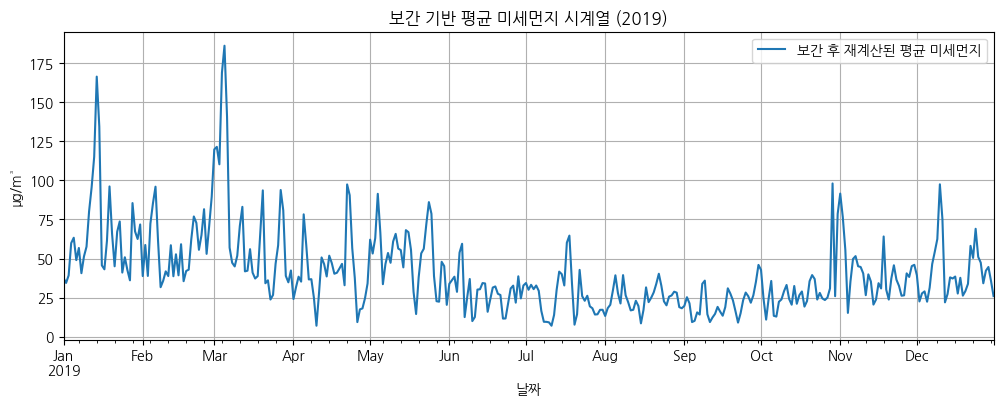

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 및 정리
df = pd.read_excel('서울대기오염_2019.xlsx')
df.columns = ['날짜', '측정소명', '미세먼지', '초미세먼지', '오존', '이산화질소', '일산화탄소', '아황산가스']
df = df[pd.to_datetime(df['날짜'], errors='coerce').notnull()]
df['날짜'] = pd.to_datetime(df['날짜'])

# ✅ 1. '측정소명 == 평균' 제거
df = df[df['측정소명'] != '평균'].copy()

# ✅ 2. 측정소별 정렬 후 보간
df.sort_values(['측정소명', '날짜'], inplace=True)
df_interpolated = df.groupby('측정소명').apply(lambda g: g.interpolate()).reset_index(drop=True)

# ✅ 3. 날짜별 평균 시계열 생성
pm_series = df_interpolated.groupby('날짜')['미세먼지'].mean()

# ✅ 4. 시각화 확인
plt.figure(figsize=(12, 4))
pm_series.plot(label='보간 후 재계산된 평균 미세먼지')
plt.title('보간 기반 평균 미세먼지 시계열 (2019)')
plt.ylabel('μg/m³')
plt.xlabel('날짜')
plt.grid()
plt.legend()
plt.show()


In [5]:
# 정상성 확인

from statsmodels.tsa.stattools import adfuller

result = adfuller(pm_series)
print("ADF p-value:", result[1])

# ADF p-value: 0.014228288927207528
# 수정 전의 p-value 0.01326704121621125

ADF p-value: 0.014228288927207528


In [6]:
from statsmodels.tsa.arima.model import ARIMA

# 1차 차분 (비정상일 경우)
model = ARIMA(pm_series, order=(1, 1, 1))  # ARIMA(p, d, q)
model_fit = model.fit()

# 예측 (예: 7일간)
forecast = model_fit.forecast(steps=7)
print(forecast)


2020-01-01    30.707134
2020-01-02    33.688236
2020-01-03    35.576214
2020-01-04    36.771900
2020-01-05    37.529146
2020-01-06    38.008722
2020-01-07    38.312445
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


NameError: name 'forecast_df' is not defined

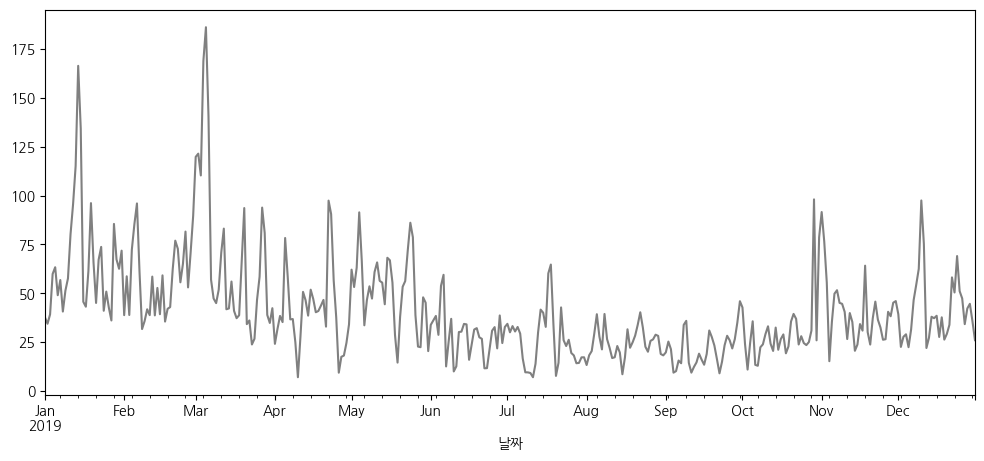

In [7]:
import matplotlib.pyplot as plt

# 시계열 재정의 (예측 시점 이전의 평균 미세먼지 시계열)
pm_series = df_interpolated.groupby('날짜')['미세먼지'].mean()


# 1. 등급별 색상 정의
grade_colors = {
    '매우 좋음': 'skyblue',
    '좋음': 'green',
    '보통': 'orange',
    '나쁨': 'red',
    '매우 나쁨': 'darkred'
}

# 2. 시각화
plt.figure(figsize=(12, 5))

# 실측값 시계열
pm_series.plot(label='실측', color='gray')

# 예측값을 등급에 따라 색상 구분하여 점으로 표시
for date, value, grade in zip(forecast_df.index, forecast_df['예측값'], forecast_df['등급']):
    plt.scatter(date, value, color=grade_colors[grade], s=100, label=grade)

# 범례 중복 제거
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# 기타 그래프 설정
plt.title('ARIMA 기반 미세먼지 예측 (등급별 색상 시각화)')
plt.ylabel('μg/m³')
plt.xlabel('날짜')
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. 학습 데이터 분리 (전체 - 7일)
train = pm_series[:-7]
test = pm_series[-7:]

# 2. 모델 적합
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# 3. 예측
pred = model_fit.forecast(steps=7)

# 4. 평가 지표
rmse = np.sqrt(mean_squared_error(test, pred))
mae = mean_absolute_error(test, pred)

print(f"모델 성능 (Test Set)")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📉 MAE : {mae:.2f}")


모델 성능 (Test Set)
📉 RMSE: 9.68
📉 MAE : 8.03


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
